In [2]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error
# from qiskit_aer import Aer
from qtcodes import XXZZQubit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
import itertools
import random

from qiskit_aer.noise import NoiseModel, depolarizing_error

seed = 10

num_qubits = 17

random.seed(seed)
cnot_depolarizing_error_physical = {}
# pauli x probability.
for key in list(itertools.combinations(range(num_qubits),2)):
    inv_key = (key[1], key[0])
    value = random.uniform(0.1, 0.2)
    # 增加3~5的错误率
    if (key[0] in [3,4,5] or key[1] in [3,4,5]) and (key[0] not in [2,6] or key[1] not in [2,6] ):
        value = 0.5
    elif (key[0] not in [3,4,5] or key[1] not in [3,4,5]) and (key[0] in [2,6] or key[1] in [2,6]):
        value = 0.05
    elif (key[0] in [3,4,5] or key[1] in [3,4,5]) and (key[0] in [2,6] or key[1] in [2,6]):
        value = 0.15
    
    cnot_depolarizing_error_physical[key] = value
    cnot_depolarizing_error_physical[inv_key] = value

In [4]:
physical_error_rate = {}
physical_error_rate['cx'] = cnot_depolarizing_error_physical

In [5]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error

def get_noise_model(physical_error_rate):

    noise_model = NoiseModel()
    for gate_name, depolarizing_error_physical in physical_error_rate.items():
    # 生成随机的噪声模型
        if gate_name == "cx":
            for qubit_pairs, dep_param in depolarizing_error_physical.items():
                # print(qubit_pairs, dep_param)
                dep_error = depolarizing_error(dep_param, 2)
                noise_model.add_quantum_error(dep_error, ['cx'], qubit_pairs)
    return noise_model

In [6]:
import sys
import os

# 获取当前文件(test.py)的目录路径
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))

# 将project目录添加到sys.path中
project_path = os.path.abspath(os.path.join(current_dir, '.'))
sys.path.append(project_path)

# 现在可以导入circuit_noise包中的logical_get_pauli_error模块
from circuit_noise.logical_get_pauli_error import get_pauli_error


qubit = XXZZQubit({'d':3,"T":1})
qubit.reset_z()
qubit.stabilize()
circ_x = qubit.circ

mapping_v2p = {}
for reg in circ_x.qregs:
    name = reg.name
    for qubits in reg:
        index = circ_x.find_bit(qubits).registers[0][1]
        v_index = name + str(index)
        p_index = circ_x.find_bit(qubits).index
        
        mapping_v2p[v_index] = p_index


In [7]:
pauli_error_set = get_pauli_error(circ= circ_x, cnot_depolarizing_error_physical = cnot_depolarizing_error_physical, mapping_v2p = mapping_v2p)

In [8]:
# circ_x.num_qubits
import math
edge_weight = {}
syndrome_graph_keys = ["X", "Z"]

for syndrome_graph_key in syndrome_graph_keys:
    weight = {}
    for key, value in pauli_error_set.items():
        if "data" in key:
            index = int(key[-1])
            if syndrome_graph_key == "X":
                # X 用于检测Z错误
                # weight[index] = -math.log(value[1]+value[2])
                weight[index] = -math.log(value[2]+value[3])
            elif syndrome_graph_key == "Z":
                # weight[index] = -math.log(value[2]+value[3])
                print(f"id: {index}, p:{value[1]+value[2]}")
                weight[index] = -math.log(value[1]+value[2])
    edge_weight[syndrome_graph_key] = weight

id: 0, p:0.19611457039601196
id: 1, p:0.18496721072363653
id: 2, p:0.04875
id: 3, p:0.4687499999999998
id: 4, p:0.48664664435461
id: 5, p:0.4465865774184405
id: 6, p:0.40344769378439804
id: 7, p:0.43787017055950106
id: 8, p:0.13831174559286838


In [14]:
1 - (1-0.19611457039601196) * (1- 0.18496721072363653) * (1-0.04875)

0.3767476740187362

In [9]:
0.04875*0.40344769378439804<0.4687499999999998*0.48664664435461*0.4465865774184405

True

In [10]:
from qtcodes import NoiseRotatedDecoder
NoiseRotatedDecoder({"d":3, "T":1}, edge_weight=edge_weight)

(<Figure size 543.058x407.294 with 1 Axes>, <Axes: >)

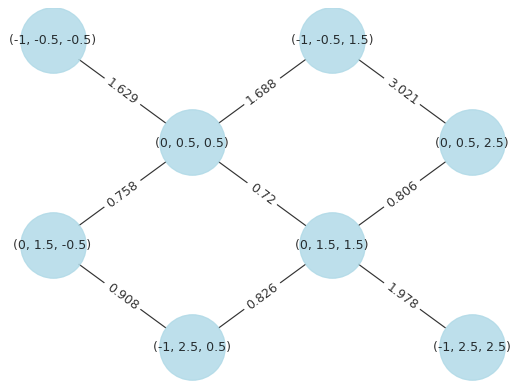

In [11]:
decoder = NoiseRotatedDecoder({"d":3,"T":1}, edge_weight)

G = decoder.S['Z']
decoder.draw(G)

In [12]:
from qtcodes import NoiseTopologicalBenchmark, NoiseTopologicalAnalysis

d = 3
T = 2

qubit = XXZZQubit({'d':d,"T":T})
qubit.reset_z()
qubit.stabilize()
# lattice_readout_z
qubit.readout_z()
# qubit.lattice_readout_z()

tool = NoiseTopologicalBenchmark(
    decoder=NoiseRotatedDecoder({"d":d, "T":T}, edge_weight=edge_weight),
    circ=qubit.circ,
    noise_model_func=get_noise_model,
    correct_logical_value = 0
)

print("\nSIMULATE: (d={},T={})\n".format(tool.decoder.params["d"], tool.decoder.params["T"]))
# physical_error_rates = [0.04,0.07, 0.10,0.13,0.16]
# tool.sweep(physical_error_rates=physical_error_rates)
# print("Done!")
tool.single(physical_error_rate = physical_error_rate, save_data = False, shots = 100000)


SIMULATE: (d=(3, 3),T=2)

readout: 0 00101101
str syndromes 0 00101101 00100000
syndromes: {'X': [], 'Z': [(0.0, 0.5, 0.5), (0.0, 1.5, -0.5), (0.0, 1.5, 1.5), (-1, -0.5, -0.5), (-1, 2.5, 0.5), (-1, -0.5, 1.5), (-1, 2.5, 2.5)]}, logical_qubit_value:0
matches: [((0.0, 0.5, 0.5), (0.0, 1.5, 1.5)), ((0.0, 1.5, -0.5), (-1, 2.5, 0.5))]
predicted_logical_value: 0, self.correct_logical_value:0
readout: 0 00110011
str syndromes 0 00110011 00110000
syndromes: {'X': [], 'Z': [(0.0, 0.5, 0.5), (0.0, 0.5, 2.5), (-1, -0.5, -0.5), (-1, 2.5, 0.5), (-1, -0.5, 1.5), (-1, 2.5, 2.5)]}, logical_qubit_value:0
matches: [((0.0, 0.5, 0.5), (0.0, 0.5, 2.5))]
predicted_logical_value: 0, self.correct_logical_value:0
readout: 0 11001100
str syndromes 0 11001100 11000000
syndromes: {'X': [], 'Z': [(0.0, 1.5, -0.5), (0.0, 1.5, 1.5), (-1, -0.5, -0.5), (-1, 2.5, 0.5), (-1, -0.5, 1.5), (-1, 2.5, 2.5)]}, logical_qubit_value:0
matches: [((0.0, 1.5, -0.5), (0.0, 1.5, 1.5))]
predicted_logical_value: 0, self.correct_logica

0.33192

In [13]:
from qtcodes import NoiseTopologicalBenchmark, NoiseTopologicalAnalysis
from qtcodes import RotatedDecoder

d = 3
T = 2

qubit = XXZZQubit({'d':d,"T":T})
qubit.reset_z()
qubit.stabilize()
# qubit.lattice_readout_z()
qubit.readout_z()

tool = NoiseTopologicalBenchmark(
    decoder=RotatedDecoder({"d":d, "T":T}),
    circ=qubit.circ,
    noise_model_func=get_noise_model,
    correct_logical_value = 0
)

print("\nSIMULATE: (d={},T={})\n".format(tool.decoder.params["d"], tool.decoder.params["T"]))
# physical_error_rates = [0.04,0.07, 0.10,0.13,0.16]
# tool.sweep(physical_error_rates=physical_error_rates)
# print("Done!")
tool.single(physical_error_rate = physical_error_rate, save_data = False, shots = 100000)


SIMULATE: (d=(3, 3),T=2)

readout: 1 01011101
str syndromes: 1 01011101 01010000
syndromes: {'X': [], 'Z': [(0.0, 0.5, 0.5), (0.0, 1.5, -0.5), (0.0, 1.5, 1.5), (-1, -0.5, -0.5), (-1, 2.5, 0.5), (-1, -0.5, 1.5), (-1, 2.5, 2.5)]}, logical_qubit_value:1
matches: [((0.0, 0.5, 0.5), (0.0, 1.5, 1.5)), ((0.0, 1.5, -0.5), (-1, 2.5, 0.5))]
predicted_logical_value: 1, self.correct_logical_value:0
readout: 1 00110010
str syndromes: 1 00110010 00110000
syndromes: {'X': [], 'Z': [(0.0, 0.5, 2.5), (-1, -0.5, -0.5), (-1, 2.5, 0.5), (-1, -0.5, 1.5), (-1, 2.5, 2.5)]}, logical_qubit_value:1
matches: [((0.0, 0.5, 2.5), (-1, -0.5, 1.5))]
predicted_logical_value: 0, self.correct_logical_value:0
readout: 0 00010011
str syndromes: 0 00010011 00010000
syndromes: {'X': [], 'Z': [(0.0, 0.5, 0.5), (0.0, 0.5, 2.5), (-1, -0.5, -0.5), (-1, 2.5, 0.5), (-1, -0.5, 1.5), (-1, 2.5, 2.5)]}, logical_qubit_value:0
matches: [((0.0, 0.5, 0.5), (0.0, 0.5, 2.5))]
predicted_logical_value: 0, self.correct_logical_value:0
readou

0.40459